# 미니 경진대회 - 네트워크 침입 여부 예측

본 파일은 경연대회에 참가하시는 모든 참가자 분들에게 제공되는 기본 코드입니다. 따라서 **본인이 원하는 대로 자유롭게 수정하면서 경진대회를 진행하세요.** 

본 코드는 플랫폼 상에서 데이터를 불러오는 방법부터 간단한 전처리 및 머신러닝 모델링 과정을 소개하고 있습니다. 나아가서 작성한 코드의 결과를 플랫폼 상에서 바로 채점하기 위한 과정까지 확인해볼 수 있습니다.

In [1]:
# 만약 라이브러리를 설치하는 명령어가 있다면, 이 셀에 몰아두는 것을 권장합니다.


In [2]:
# 🚨 브라우저 환경 최적화 설정 🚨
import warnings
warnings.filterwarnings('ignore')

# 메모리 사용량 최적화
import gc
import psutil
import os

# matplotlib 백엔드 설정 (브라우저 환경에서 안정성 향상)
# import matplotlib
# matplotlib.use('Agg')  # GUI 백엔드 대신 Agg 사용
import matplotlib.pyplot as plt

# 시각화 설정 최적화
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['font.size'] = 10

# pandas 메모리 최적화
import pandas as pd
pd.options.mode.chained_assignment = None  # SettingWithCopyWarning 억제

# 메모리 사용량 모니터링 함수
def print_memory_usage():
    """현재 메모리 사용량을 출력합니다."""
    try:
        process = psutil.Process(os.getpid())
        memory_mb = process.memory_info().rss / 1024 / 1024
        print(f"현재 메모리 사용량: {memory_mb:.2f} MB")
    except:
        print("메모리 사용량 확인 불가")

# 가비지 컬렉션 강제 실행 함수
def force_gc():
    """가비지 컬렉션을 강제로 실행합니다."""
    gc.collect()
    print("가비지 컬렉션 완료")

print("🚀 브라우저 환경 최적화 설정 완료!")
print_memory_usage()

🚀 브라우저 환경 최적화 설정 완료!
현재 메모리 사용량: 124.89 MB


In [3]:
# 라이브러리 임포트
import numpy as np
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.preprocessing import LabelEncoder

data_dir = "/mnt/elice/dataset"
print("📚 라이브러리 임포트 완료!")

📚 라이브러리 임포트 완료!


## 데이터 불러오기

학습 데이터와 테스트 데이터를 불러옵니다.
  - 데이터셋 구성: Packet Flow rate, Protocol 등 41개의 Feature로 구성된 데이터셋. 
  - 주요 컬럼: Dst Port (Destination port), Protocol, Flow Duration, Tot Fwd Pkts (Total forward packets), Tot Bwd Pkts (Total backward packets)
    - 전체 컬럼에 대한 설명은 경진대회 설명을 확인해주세요.
  - 타겟 변수 (예측해야 하는 대상): Label


In [4]:
# 데이터 불러오기 (메모리 최적화)
print("📊 데이터 불러오기 시작...")
print_memory_usage()

train_df = pd.read_csv(os.path.join(data_dir, "train.csv"), index_col="unique_id")
test_df = pd.read_csv(os.path.join(data_dir, "test.csv"), index_col="unique_id")

print(f"✅ Train Data 크기: {train_df.shape}")
print(f"✅ Test Data 크기: {test_df.shape}")
print_memory_usage()

📊 데이터 불러오기 시작...
현재 메모리 사용량: 194.61 MB
✅ Train Data 크기: (4638804, 42)
✅ Test Data 크기: (1159701, 42)
현재 메모리 사용량: 4210.55 MB


# 데이터 확인하기

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4638804 entries, 1143575A to 6700647I
Data columns (total 42 columns):
 #   Column            Dtype  
---  ------            -----  
 0   Dst Port          object 
 1   Protocol          int64  
 2   Timestamp         object 
 3   Flow Duration     int64  
 4   Tot Fwd Pkts      int64  
 5   Tot Bwd Pkts      int64  
 6   TotLen Fwd Pkts   int64  
 7   TotLen Bwd Pkts   float64
 8   Flow Byts/s       float64
 9   Flow Pkts/s       float64
 10  Flow IAT Mean     float64
 11  Flow IAT Std      float64
 12  Flow IAT Max      float64
 13  Flow IAT Min      float64
 14  Pkt Len Min       int64  
 15  Pkt Len Max       int64  
 16  Pkt Len Mean      float64
 17  Pkt Len Std       float64
 18  Pkt Len Var       float64
 19  FIN Flag Cnt      int64  
 20  SYN Flag Cnt      int64  
 21  RST Flag Cnt      int64  
 22  PSH Flag Cnt      int64  
 23  ACK Flag Cnt      int64  
 24  URG Flag Cnt      int64  
 25  CWE Flag Count    int64  
 26  ECE Flag Cn

In [6]:
train_df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Flow Byts/s,Flow Pkts/s,...,Subflow Bwd Byts,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
unique_id,,,,,,,,,,,,,,,,,,,,,
1143575A,B,17,2018-03-01 09:28:38,1920,1,1,47,107.0,80208.333330,1041.666667,...,107,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,Benign
3422448M,B,17,2018-02-23 10:04:12,2307,1,1,39,243.0,122236.671001,866.926745,...,243,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,Benign
7243044R,B,17,2018-03-01 04:31:24,1772,1,1,42,182.0,126410.835200,1128.668172,...,182,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,Benign
9908051J,A,6,2018-02-21 02:15:24,13527,3,4,266,935.0,88785.392180,517.483551,...,935,0.0000,0.0000,0.0,0.0,0.0,0.0000,0.0,0.0,DDOS
5842623U,C,6,2018-02-28 02:22:42,60854466,16,15,1577,4799.0,104.774562,0.509412,...,4799,122370.1667,129788.5834,387300.0,69358.0,10000000.0,16311.0867,10000000.0,9968490.0,Infilteration


이상치와 결측치를 확인해보자. 


In [7]:
# 1. 각 컬럼별 결측치(NaN) 개수 확인
missing_values = train_df.isnull().sum()
# 결측치가 존재하는 컬럼만 필터링해서 출력
missing_values_exist = missing_values[missing_values > 0]

print("\n--- 결측치(NaN)가 존재하는 컬럼 및 개수 ---")
if not missing_values_exist.empty:
    print(missing_values_exist)
else:
    print("결측치(NaN)가 존재하는 컬럼이 없습니다.")

# 2. 숫자형 컬럼에서 inf 값 개수 확인
numeric_df = train_df.select_dtypes(include=[np.number])
inf_counts_numeric = numeric_df.apply(lambda x: np.isinf(x).sum())
# inf 값이 존재하는 컬럼만 필터링해서 출력
inf_counts_exist = inf_counts_numeric[inf_counts_numeric > 0]

print("\n--- inf 값이 존재하는 숫자형 컬럼 및 개수 ---")
if not inf_counts_exist.empty:
    print(inf_counts_exist)
else:
    print("inf 값이 존재하는 숫자형 컬럼이 없습니다.")

# 3. 전체 데이터(행) 개수 확인
total_entries = train_df.shape[0]
print(f"\n--- 전체 데이터(행) 개수: {total_entries} ---")

# --- 결측치 또는 inf 값이 포함된 '고유한 행'의 개수 계산 ---

# 1. NaN 값이 하나라도 있는 행을 True로 표시
nan_rows_mask = train_df.isnull().any(axis=1) # axis=1은 행 기준으로 하나라도 True면 True

# 2. inf 값이 하나라도 있는 행을 True로 표시 (숫자형 컬럼만)
# 모든 컬럼에 np.isinf를 바로 적용하면 TypeError가 날 수 있으므로, 숫자형 컬럼에만 적용 후 합쳐서 판단
inf_rows_mask_numeric = train_df.select_dtypes(include=[np.number]).apply(lambda col: np.isinf(col)).any(axis=1)

# 3. NaN이 있거나 inf가 있는 모든 행의 통합 마스크
# 두 마스크를 OR(|) 연산으로 합쳐서, NaN이나 inf 중 하나라도 있는 행을 모두 True로 표시
problematic_rows_mask = nan_rows_mask | inf_rows_mask_numeric

# 4. 문제성 행의 총 개수 (중복 제외)
total_problematic_rows = problematic_rows_mask.sum()

print("\n--- 결측치 또는 inf 값이 포함된 고유한 행의 개수 및 비율 ---")
print(f"결측치(NaN) 또는 inf 값이 포함된 고유한 행의 총 개수: {total_problematic_rows}개")

if total_entries > 0:
    problematic_ratio = (total_problematic_rows / total_entries * 100)
    print(f"전체 데이터 대비 고유한 문제성 행의 비율: {problematic_ratio:.4f}%")
else:
    print("데이터가 비어있어 비율을 계산할 수 없습니다.")


--- 결측치(NaN)가 존재하는 컬럼 및 개수 ---
Flow Byts/s    9
dtype: int64

--- inf 값이 존재하는 숫자형 컬럼 및 개수 ---
Flow Byts/s    597
Flow Pkts/s    606
dtype: int64

--- 전체 데이터(행) 개수: 4638804 ---

--- 결측치 또는 inf 값이 포함된 고유한 행의 개수 및 비율 ---
결측치(NaN) 또는 inf 값이 포함된 고유한 행의 총 개수: 606개
전체 데이터 대비 고유한 문제성 행의 비율: 0.0131%


매우 작은 값이므로 해당 행을 제거한다. 

In [8]:
# 결측치 및 inf 값 처리 (메모리 효율적으로)
print("🧹 데이터 정리 시작...")
print_memory_usage()

# inf 값을 NaN으로 변환
train_df['Flow Byts/s'] = train_df['Flow Byts/s'].replace([np.inf, -np.inf], np.nan)
train_df['Flow Pkts/s'] = train_df['Flow Pkts/s'].replace([np.inf, -np.inf], np.nan)

# 문제가 있는 행 제거
train_df_cleaned = train_df.dropna(subset=['Flow Byts/s', 'Flow Pkts/s'])

print(f"제거 전: {train_df.shape[0]} 행")
print(f"제거 후: {train_df_cleaned.shape[0]} 행")
print(f"제거된 행: {train_df.shape[0] - train_df_cleaned.shape[0]} 행")

# 원본 데이터 메모리 해제
del train_df
force_gc()
print_memory_usage()

🧹 데이터 정리 시작...
현재 메모리 사용량: 5592.29 MB
제거 전: 4638804 행
제거 후: 4638198 행
제거된 행: 606 행
가비지 컬렉션 완료
현재 메모리 사용량: 6867.08 MB


네트워크의 침임여부를 분류하려면 비정상 통신의 특징을 알아야한다고 생각했다.
따라서 label 컬럼이 가리키고 있는 각 값과 다른 컬럼들과의 상관관계를 확인해보자.

상관관계를 확인하기에 앞서 Object type인 Dst Port, Timestamp의 형태를 바꾸자.

In [9]:
print("Dst Port의 고유 값:")
print(train_df_cleaned['Dst Port'].unique())


Dst Port의 고유 값:
['B' 'A' 'C' 'E' 'D' 'F' 'G']


Dst Port의 값이 A, B, C, D, E, F, G로 나누어져 있다.

1) A부터 G까지 독립적인 의미를 가지는 포트 번호의 값
2) 서로 간에 순서나 크기를 나타내는 값이 아님
> 원-핫 인코딩이 적절한 듯 보인다. 

In [10]:
# 데이터 전처리 (메모리 효율적으로)
print("🔧 데이터 전처리 시작...")

# 복사본 생성
train_df_processed = train_df_cleaned.copy()

# Timestamp 처리
train_df_processed['Timestamp'] = pd.to_datetime(train_df_processed['Timestamp'], errors='coerce')
train_df_processed.dropna(subset=['Timestamp'], inplace=True)

# 시간 관련 Feature 생성
train_df_processed['Day_of_Week'] = train_df_processed['Timestamp'].dt.dayofweek
train_df_processed['Hour_of_Day'] = train_df_processed['Timestamp'].dt.hour

# Dst Port 원-핫 인코딩
train_df_processed = pd.get_dummies(train_df_processed, columns=['Dst Port'], prefix='Dst_Port', drop_first=True)

print("--- 최종 train_df_processed 컬럼 목록 ---")
print(train_df_processed.columns)
print("\n")
print("--- 최종 DataFrame 정보 ---")
print(train_df_processed.info())

# 원본 데이터 메모리 해제
del train_df_cleaned
force_gc()

🔧 데이터 전처리 시작...
--- 최종 train_df_processed 컬럼 목록 ---
Index(['Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Flow Byts/s',
       'Flow Pkts/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts',
       'Subflow Bwd Byts', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label',
       'Day_of_Week', 'Hour_of_Day', 'Dst_Port_B', 'Dst_Port_C', 'Dst_Port_D',
       'Dst_Port_E', 'Dst_Port_F', 'Dst_Port_G'],
      dtype='object')


--- 최종 DataFrame 정보 ---
<class 'pandas.core.frame.DataFrame'>
Index: 4638198 entries

통계량 비교나 시각화를 활용하는 것이 좋겠다.

## 1. 통계량 비교

In [11]:
# --- 판다스 출력 옵션 설정 ---
# 모든 컬럼을 볼 수 있도록 최대 컬럼 수를 늘려줘
pd.set_option('display.max_columns', None)
# DataFrame이 잘리지 않도록 표시 너비를 충분히 늘려줘
pd.set_option('display.width', 100)

In [12]:
features_to_compare_simultaneously = [
    'Protocol',
    'Flow Duration',
    'Tot Fwd Pkts',
    'Tot Bwd Pkts',
    'TotLen Fwd Pkts',
    'TotLen Bwd Pkts',
    'Flow Byts/s',
    'Flow Pkts/s',
    'Flow IAT Mean',
    'Flow IAT Std',
    'Flow IAT Max',
    'Flow IAT Min',
    'Pkt Len Mean',
    'Pkt Len Std',
    'Pkt Len Max',
    'Pkt Len Min',
    'Pkt Len Var',
    'FIN Flag Cnt',
    'SYN Flag Cnt',
    'RST Flag Cnt',
    'PSH Flag Cnt',
    'ACK Flag Cnt',
    'URG Flag Cnt',
    'ECE Flag Cnt',
    'CWE Flag Count',
    'Down/Up Ratio',
    'Pkt Size Avg',
    'Subflow Fwd Pkts',
    'Subflow Fwd Byts',
    'Subflow Bwd Pkts',
    'Subflow Bwd Byts',
    'Active Mean',
    'Active Std',
    'Active Max',
    'Active Min',
    'Idle Mean',
    'Idle Std',
    'Idle Max',
    'Idle Min',
    'Dst_Port_B',
    'Dst_Port_C',
    'Dst_Port_D',# Dst_Port 관련 Feature도 중요하니 포함
    'Dst_Port_E',
    'Dst_Port_F',
    'Dst_Port_G'
]

## 각 Feature에 대해 계산하고 싶은 통계량들을 딕셔너리 형태로 정의
aggregation_dict = {col: ['mean', 'median', 'std', 'min', 'max'] for col in features_to_compare_simultaneously}

# 'Label' 컬럼을 기준으로 그룹화하고, 정의된 통계량들을 한 번에 계산
comparison_table = train_df_processed.groupby('Label').agg(aggregation_dict)

# 멀티 인덱스 컬럼을 더 보기 좋게 만들기
comparison_table.columns = ['_'.join(col).strip() for col in comparison_table.columns.values]

print("--- 각 Label 그룹별 핵심 Feature 통계치 동시 비교 ---")
print(comparison_table) 

--- 각 Label 그룹별 핵심 Feature 통계치 동시 비교 ---
               Protocol_mean  Protocol_median  Protocol_std  Protocol_min  Protocol_max  \
Label                                                                                     
Benign             10.108885              6.0      5.321166             6            17   
Brute Force         6.000000              6.0      0.000000             6             6   
DDOS                6.027670              6.0      0.551006             6            17   
DoS                 6.000000              6.0      0.000000             6             6   
Infilteration      11.017326              6.0      5.478817             6            17   

               Flow Duration_mean  Flow Duration_median  Flow Duration_std  Flow Duration_min  \
Label                                                                                           
Benign               1.384912e+07               81116.0       3.265410e+07                  1   
Brute Force          1.126484e

### 1. Benign (정상 통신):

다양한 Protocol 사용 (TCP, UDP).

Flow Duration은 대부분 짧지만, 매우 긴 이상치 존재.

Tot Fwd Pkts/TotLen Fwd Pkts, Tot Bwd Pkts/TotLen Bwd Pkts가 양방향으로 균형 있게 발생.

Flow Pkts/s는 공격 유형보다 낮음.

Flow IAT는 가변적이고 긴 유휴 시간이 존재.

Pkt Len Mean/Max가 공격 유형보다 높음 (상대적으로 긴 패킷).

Down/Up Ratio가 양방향 통신을 나타냄.

Active/Idle 시간이 의미 있는 값을 가짐.

Dst_Port는 B, C, D, F 등 다양한 포트를 낮은 비율로 사용.

### 2. Brute Force (브루트 포스 공격):

오직 TCP (Protocol: 6) 사용.

매우 짧은 Flow Duration (median: 6.0).

압도적으로 높은 Flow Pkts/s (median: 333333).

매우 낮은 Pkt Len Mean/Max/Min (median: 0.0).

높은 Down/Up Ratio (median: 1.0).

모든 Active/Idle 관련 Feature가 0.0 (끊김 없는 공격).

높은 PSH Flag Cnt (median: 1.0) 및 URG Flag Cnt (mean: 0.245).

SYN Flag Cnt가 0.0.

Dst_Port_E와 Dst_Port_G에 압도적으로 집중 (median: 1.0 또는 mean: 0.491).

### 3. DDOS (분산 서비스 거부 공격):

대부분 TCP이나 일부 UDP 포함.

매우 짧은 Flow Duration (median: 6588.0).

압도적으로 높은 Tot Fwd Pkts/TotLen Fwd Pkts (mean 기준).

매우 낮은 Tot Bwd Pkts/TotLen Bwd Pkts (median: 0.0) 및 Down/Up Ratio (median: 0.0) (단방향 공격).

모든 Active/Idle 관련 Feature가 0.0 (끊김 없는 공격).

높은 ACK Flag Cnt (median: 1.0).

SYN Flag Cnt가 0.0.

우리가 정의한 Dst_Port Feature들에서 특정 포트 집중 경향이 없음 (mean: 0.0).
### 4. DoS (서비스 거부 공격):

오직 TCP (Protocol: 6) 사용.

Flow Duration은 짧지만, 매우 긴 이상치 존재.

매우 높은 Flow Pkts/s (mean: 154291).

가장 낮은 Pkt Len Mean/Max/Min (median: 0.0).

매우 낮은 Tot Bwd Pkts/TotLen Bwd Pkts (median: 0.0) 및 Down/Up Ratio (median: 0.0) (단방향 공격).

Idle Mean은 높지만 median은 0.0 (일부 흐름에 긴 유휴 시간 이상치 존재).

높은 ACK Flag Cnt (median: 1.0).

Dst_Port_E에 집중 (mean: 0.207).

### 5. Infilteration (침투 공격):

다양한 Protocol 사용 (TCP, UDP).

Flow Duration은 대부분 짧지만, 매우 긴 이상치 존재.

Tot Fwd Pkts/TotLen Fwd Pkts, Tot Bwd Pkts/TotLen Bwd Pkts가 양방향으로 균형 있게 발생.

Flow Pkts/s는 공격 유형보다 낮음.

Flow IAT는 가변적이고 긴 유휴 시간이 존재.

Pkt Len Mean/Max가 공격 유형보다 높음 (상대적으로 긴 패킷).

Down/Up Ratio가 양방향 통신을 나타냄.

Active/Idle 시간이 의미 있는 값을 가짐.

RST Flag Cnt가 상대적으로 높음.

Dst_Port는 B, C, D, F 등 다양한 포트를 낮은 비율로 사용하며, 특히 Dst_Port_C에서 Benign보다 높은 비율을 보임.

## Feature 선택 전략
1. 중복되거나 정보 가치가 낮은 Feature 제거 (Redundancy & Low Variance)
1) Subflow 관련 Feature
-Tot Fwd Pkts/TotLen Fwd Pkts와 Tot Bwd Pkts/TotLen Bwd Pkts와 Subflow 관련 Feature들이 거의 동일한 통계치를 보였잖아. 이건 정보의 중복성이 높다는 의미야.
- 대부분의 Flow가 단일 Subflow로 구성: 실제 네트워크 트래픽에서는 모든 Flow가 여러 Subflow를 가지는 건 아니야. 특히 악성 트래픽의 경우, 단순하고 일방적인 통신(예: DoS, Brute Force)이 많아서 대부분의 Flow가 하나의 Subflow로만 구성될 수 있어. 이 경우 Subflow의 통계치는 Tot Flow의 통계치와 같아지겠지.
- Tot Flow 관련 Feature만 남기기

2) min/max 값이 False/True로만 나오는 Feature: Dst_Port 관련 Feature들처럼 min이 False이고 max가 True인 경우가 많았지? 이건 해당 Feature가 이진 값(0 또는 1)으로만 구성되어 있다는 뜻이야. 이 경우 std (표준편차)나 mean (평균)만으로도 충분히 정보가 전달되니까, min/max 컬럼 자체는 굳이 남길 필요가 없을 수도 있어. 어떻게 생각해?

2. 분산이 너무 낮거나 (거의 상수) 너무 높은 Feature 고려 (Variance)
분산이 너무 낮은 Feature: 만약 어떤 Feature의 std (표준편차)가 거의 0에 가깝다면, 그 Feature는 모든 샘플에서 거의 같은 값을 가진다는 의미야. 이런 Feature는 모델 학습에 큰 도움이 되지 않을 수 있어서 제거를 고려해볼 수 있어. (예: Brute Force나 DDOS에서 Protocol의 std가 0.0인 것처럼, 특정 그룹 내에서는 분산이 없지만 그룹 간에는 차이가 있는 경우는 유용함)


높은 패턴 기여도:

요일: 네트워크 트래픽이나 공격 패턴은 요일에 따라 크게 달라지는 경향이 있어. 예를 들어, 주중 업무 시간과 주말에는 정상 트래픽 패턴이 다를 거고, 공격자들도 특정 요일에 활동을 집중하거나(예: 주말 새벽을 노린다든지) 하는 패턴을 보일 수 있어.

시간 (하루 중): 요일만큼이나 하루 중 특정 시간대도 중요한 패턴을 보여줘. 업무 시간, 퇴근 후 저녁 시간, 심야 시간 등에 따라 정상 트래픽 양이 달라지고, 이에 맞춰 공격자들이 특정 시간대에 공격을 시도하는 경향이 흔하거든.

물론, 지금은 요일과 시간만 추출했지만, 만약 모델 학습 후에 시간 관련 Feature가 부족하다는 판단이 들거나, 더 깊은 시간 기반의 패턴을 찾아야 할 필요가 있다면 언제든지 월, 주차 등 다른 시간 단위 Feature를 추가로 추출해서 실험해볼 수 있어. 이건 데이터 분석 과정에서 유연하게 가져갈 수 있는 부분이야!

In [13]:
# 'Label' 컬럼은 타겟 변수이므로 표준편차 계산에서 제외
# 숫자형이 아닌 컬럼도 오류를 피하기 위해 제외
numeric_cols = train_df_processed.select_dtypes(include=['number']).columns
if 'Label' in numeric_cols:
    numeric_cols = numeric_cols.drop('Label')

feature_std_dev = train_df_processed[numeric_cols].std()

# 결과 출력
print("✨ 각 Feature의 표준편차 ✨")
print(feature_std_dev)

# 표준편차가 매우 낮은 Feature들을 확인하기 쉽게 정렬해서 볼 수도 있어
print("\n🔍 표준편차가 낮은 순서대로 정렬 (상위 20개) 🔍")
print(feature_std_dev.sort_values().head(20))

✨ 각 Feature의 표준편차 ✨
Protocol            4.852002e+00
Flow Duration       2.849416e+07
Tot Fwd Pkts        2.090176e+03
Tot Bwd Pkts        2.023885e+02
TotLen Fwd Pkts     6.833542e+04
TotLen Bwd Pkts     2.878956e+05
Flow Byts/s         1.718679e+06
Flow Pkts/s         2.766265e+05
Flow IAT Mean       7.869151e+06
Flow IAT Std        3.665775e+06
Flow IAT Max        1.349901e+07
Flow IAT Min        7.708352e+06
Pkt Len Min         1.861343e+01
Pkt Len Max         5.219804e+02
Pkt Len Mean        1.117931e+02
Pkt Len Std         1.632915e+02
Pkt Len Var         1.105841e+05
FIN Flag Cnt        4.473571e-02
SYN Flag Cnt        1.582642e-01
RST Flag Cnt        3.427270e-01
PSH Flag Cnt        4.961884e-01
ACK Flag Cnt        4.568556e-01
URG Flag Cnt        1.408047e-01
CWE Flag Count      6.500463e-03
ECE Flag Cnt        3.427275e-01
Down/Up Ratio       7.591060e-01
Pkt Size Avg        1.154942e+02
Subflow Fwd Pkts    2.090176e+03
Subflow Fwd Byts    6.833542e+04
Subflow Bwd Pkts    2.0

1. 네가 정렬한 표준편차가 낮은 순서대로 정렬 (상위 20개) 부분을 보자.

CWE Flag Count (0.006500):

CWE Flag Count는 제거를 강력히 고려해볼 만한 Feature야. 대부분의 데이터에서 거의 변화가 없을 가능성이 높아 모델 학습에 기여하는 바가 적을 거야.

나머지 Flag Count Feature들 (FIN Flag Cnt, URG Flag Cnt, SYN Flag Cnt, RST Flag Cnt, ECE Flag Cnt, ACK Flag Cnt, PSH Flag Cnt)은 비록 표준편차가 0에 가깝지만, 우리 초기 분석에서 특정 공격 유형(예: Brute Force의 PSH, ACK Flag)에서 유의미한 패턴을 보였던 것을 기억해야 해. 이 Feature들은 각 Label 그룹 내에서는 분산이 낮을 수 있어도, Label 간에는 중요한 차이를 만들어내므로 제거하지 않고 유지하는 것이 더 좋을 것 같아.

2.나중에 전처리할 Feature: 표준편차가 높은 Flow Duration, Tot Fwd Pkts, Tot Bwd Pkts, TotLen Fwd Pkts, TotLen Bwd Pkts, Flow Byts/s, Flow Pkts/s, Flow IAT 관련 Feature들, Pkt Len 관련 Feature들, Active 및 Idle 관련 Feature들은 나중에 로그 변환 및 스케일링을 통해 값의 범위를 조정해야 해.


In [14]:
from sklearn.preprocessing import PowerTransformer

# --- 1. Subflow 관련 Feature 제거 ---
columns_to_drop_subflow = [col for col in train_df_processed.columns if col.startswith('Subflow')]
if columns_to_drop_subflow: # 제거할 컬럼이 있을 경우에만 drop 수행
    train_df_processed = train_df_processed.drop(columns=columns_to_drop_subflow)
    print(f"1. Subflow 관련 Feature {columns_to_drop_subflow} 제거 완료. ✅")
else:
    print("1. Subflow 관련 Feature가 없습니다. (이미 제거되었거나 해당 컬럼 없음)")


# --- 2. Dst_Port min/max 컬럼 제거 ---
# Dst_Port는 원-핫 인코딩 후 boolean 타입이므로 min/max 컬럼이 생기지 않습니다. 이 단계는 필요 없습니다.
# columns_to_drop_dst_port_minmax = [col for col in train_df_processed.columns if col.startswith('Dst_Port_') and (col.endswith('_min') or col.endswith('_max'))]
# if columns_to_drop_dst_port_minmax:
#     train_df_processed = train_df_processed.drop(columns=columns_to_drop_dst_port_minmax)
#     print(f"2. Dst_Port min/max 컬럼 {columns_to_drop_dst_port_minmax} 제거 완료. ✅")
# else:
#     print("2. Dst_Port min/max 컬럼이 없습니다.")


# --- 3. (초기 필터링) 모든 Label 그룹에서 분산이 극도로 낮은 Feature 제거 ---
# 이 단계는 Timestamp 처리 전에 숫자형 컬럼에서 불필요한 것들을 미리 거릅니다.
# CWE Flag Count는 여기서 걸러질 가능성이 높지만, 명시적으로 제거하는 단계도 유지합니다.
low_variance_cols_initial = []
# 숫자형 컬럼만 선택
numeric_cols_initial = train_df_processed.select_dtypes(include=[np.number]).columns.tolist()
# Label 컬럼은 제외
if 'Label' in numeric_cols_initial:
    numeric_cols_initial.remove('Label')

for col in numeric_cols_initial:
    # std() 값이 0에 극도로 가까운 (예: 0.00001 미만) 컬럼 제거
    if train_df_processed[col].std() < 0.00001:
        low_variance_cols_initial.append(col)

if low_variance_cols_initial:
    train_df_processed = train_df_processed.drop(columns=low_variance_cols_initial)
    print(f"3. 초기 분산이 극도로 낮은 Feature {low_variance_cols_initial} 제거 완료. ✅")
else:
    print("3. 초기 분산이 극도로 낮은 Feature가 없습니다.")


# --- 4. CWE Flag Count Feature 제거 ---
column_to_drop_cwe = ['CWE Flag Count']
if column_to_drop_cwe[0] in train_df_processed.columns:
    train_df_processed = train_df_processed.drop(columns=column_to_drop_cwe)
    print(f"4. '{column_to_drop_cwe[0]}' 컬럼이 성공적으로 제거되었습니다. ✅")
else:
    print(f"4. '{column_to_drop_cwe[0]}' 컬럼이 데이터프레임에 없습니다. (이미 제거되었거나 이름이 다를 수 있습니다.)")


# --- 5. Timestamp 컬럼 처리 (가장 중요! 여기서 Day_of_Week, Hour_of_Day 생성) ---
# 'Timestamp' 컬럼이 문자열이라면 datetime 객체로 변환
if 'Timestamp' in train_df_processed.columns:
    # errors='coerce'를 사용하여 변환 불가능한 값은 NaT (Not a Time)으로 만듭니다.
    train_df_processed['Timestamp'] = pd.to_datetime(train_df_processed['Timestamp'], errors='coerce')

    # NaT가 된 행은 시간 관련 Feature를 만들 수 없으므로 제거하거나 다른 방법으로 처리해야 합니다.
    # 여기서는 간단히 해당 행을 제거하겠습니다. (NaT가 많지 않다고 가정)
    train_df_processed.dropna(subset=['Timestamp'], inplace=True)

    train_df_processed['Day_of_Week'] = train_df_processed['Timestamp'].dt.dayofweek
    train_df_processed['Hour_of_Day'] = train_df_processed['Timestamp'].dt.hour
    train_df_processed = train_df_processed.drop(columns=['Timestamp'])
    print("5. Timestamp 컬럼 처리 및 Day_of_Week, Hour_of_Day 생성 완료. ✅")
else:
    print("5. 'Timestamp' 컬럼이 데이터프레임에 없습니다. Timestamp 처리를 건너뜁니다.")


# --- 5.5. Day_of_Week와 Hour_of_Day 주기적 변환 (새로 추가되는 부분!) ---
# Day_of_Week (0-6)
train_df_processed['Day_of_Week_sin'] = np.sin(2 * np.pi * train_df_processed['Day_of_Week'] / 7)
train_df_processed['Day_of_Week_cos'] = np.cos(2 * np.pi * train_df_processed['Day_of_Week'] / 7)

# Hour_of_Day (0-23)
train_df_processed['Hour_of_Day_sin'] = np.sin(2 * np.pi * train_df_processed['Hour_of_Day'] / 24)
train_df_processed['Hour_of_Day_cos'] = np.cos(2 * np.pi * train_df_processed['Hour_of_Day'] / 24)


# --- 6. (재확인) 모든 Label 그룹에서 분산이 극도로 낮은 Feature 제거 (Timestamp 처리 후 최종 필터링) ---
# Timestamp 처리 후 새로 생성된 컬럼 (Day_of_Week_sin/cos, Hour_of_Day_sin/cos)의 분산도 여기에 포함하여 확인 가능
# 위 3번에서 제거되지 않았고 Timestamp 관련 컬럼이 아니었던 나머지 저분산 컬럼들이 여기서 제거될 수 있습니다.
low_variance_cols_final = []
numeric_cols_final = train_df_processed.select_dtypes(include=[np.number]).columns.tolist()
if 'Label' in numeric_cols_final:
    numeric_cols_final.remove('Label')
# 주기적 변환된 컬럼은 여기서 제외
cyclic_cols = ['Day_of_Week_sin', 'Day_of_Week_cos', 'Hour_of_Day_sin', 'Hour_of_Day_cos']
numeric_cols_final = [col for col in numeric_cols_final if col not in cyclic_cols]

for col in numeric_cols_final:
    if train_df_processed[col].std() < 0.00001:
         low_variance_cols_final.append(col)

if low_variance_cols_final:
    train_df_processed = train_df_processed.drop(columns=low_variance_cols_final)
    print(f"6. 최종 분산이 극도로 낮은 Feature {low_variance_cols_final} 제거 완료. ✅")
else:
    print("6. 최종 분산이 극도로 낮은 Feature가 없습니다.")


# --- 7. Power Transformer (Yeo-Johnson) 적용 ---
# 고분산 및 왜곡된 분포 컬럼들에 적용합니다.
# 로그 변환 시도했던 컬럼 목록을 기반으로 하되, 실제 존재하는 숫자형 컬럼만 선택
cols_to_transform = [
    'Flow Duration', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts',
    'Flow Byts/s', 'Flow Pkts/s', 'Pkt Len Var',
    'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
    'Active Mean', 'Active Std', 'Active Max', 'Active Min',
    'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min',
    # Tot Fwd Pkts, Tot Bwd Pkts 등 카운트 기반 컬럼도 포함 가능
    'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Down/Up Ratio', 'Pkt Size Avg'
]

# 실제 데이터프레임에 존재하는 숫자형 컬럼만 선택 (Label, Dst_Port_* 등 제외)
numeric_cols_for_transform = train_df_processed.select_dtypes(include=[np.number]).columns.tolist()
if 'Label' in numeric_cols_for_transform:
    numeric_cols_for_transform.remove('Label')
# 주기적 변환된 컬럼은 제외
numeric_cols_for_transform = [col for col in numeric_cols_for_transform if col not in cyclic_cols]

# 최종 변환 대상 컬럼 목록 (둘의 교집합)
final_cols_to_transform = [col for col in cols_to_transform if col in numeric_cols_for_transform]

print(f"\n7. Power Transformer (Yeo-Johnson)를 적용할 컬럼: {final_cols_to_transform}")

# PowerTransformer 객체 생성 (Yeo-Johnson 변환)
# standardize=True로 설정하면 변환 후 자동으로 평균 0, 분산 1로 스케일링됩니다.
power_transformer = PowerTransformer(method='yeo-johnson', standardize=True, copy=False) # copy=False로 원본 DF에 바로 적용 시도

# 변환 적용
# fit_transform은 2D 배열을 기대하므로, DataFrame에서 해당 컬럼들만 선택하여 적용
# 변환된 결과는 numpy 배열이므로, 다시 DataFrame으로 할당해야 합니다.
train_df_processed[final_cols_to_transform] = power_transformer.fit_transform(train_df_processed[final_cols_to_transform])

print("7. Power Transformer (Yeo-Johnson) 적용 완료. ✅")


# --- 8. StandardScaler (PowerTransformer로 변환되지 않은 나머지 숫자형 컬럼) ---
# PowerTransformer의 standardize=True 때문에 변환된 컬럼은 다시 스케일링할 필요가 없습니다.
# 따라서 Label, 주기적 변환 컬럼, PowerTransformer로 변환된 컬럼을 제외한 나머지 숫자형 컬럼에만 StandardScaler 적용
cols_to_scale_standard = train_df_processed.select_dtypes(include=['number']).columns.tolist()
if 'Label' in cols_to_scale_standard: cols_to_scale_standard.remove('Label')
# 주기적 변환된 컬럼은 제외
cols_to_scale_standard = [col for col in cols_to_scale_standard if col not in cyclic_cols]
# PowerTransformer로 변환된 컬럼은 제외
cols_to_scale_standard = [col for col in cols_to_scale_standard if col not in final_cols_to_transform]


print(f"\n8. StandardScaler를 적용할 컬럼 (Label, 주기적 변환, PowerTransformer 제외): {cols_to_scale_standard}")

if cols_to_scale_standard: # 스케일링할 컬럼이 남아있을 경우에만 스케일링 수행
    scaler = StandardScaler()
    train_df_processed[cols_to_scale_standard] = scaler.fit_transform(train_df_processed[cols_to_scale_standard])
    print("8. StandardScaler 적용 완료. ✅")
else:
    print("8. StandardScaler를 적용할 컬럼이 없습니다.")


print("\n✨ 모든 전처리 단계 완료! ✨")

1. Subflow 관련 Feature ['Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts'] 제거 완료. ✅
3. 초기 분산이 극도로 낮은 Feature가 없습니다.
4. 'CWE Flag Count' 컬럼이 성공적으로 제거되었습니다. ✅
5. Timestamp 컬럼 처리 및 Day_of_Week, Hour_of_Day 생성 완료. ✅
6. 최종 분산이 극도로 낮은 Feature가 없습니다.

7. Power Transformer (Yeo-Johnson)를 적용할 컬럼: ['Flow Duration', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Flow Byts/s', 'Flow Pkts/s', 'Pkt Len Var', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Down/Up Ratio', 'Pkt Size Avg']
7. Power Transformer (Yeo-Johnson) 적용 완료. ✅

8. StandardScaler를 적용할 컬럼 (Label, 주기적 변환, PowerTransformer 제외): ['Protocol', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'ECE Flag Cnt', 'Day_of_Week', 'Hour_of_Day']
8. StandardScaler 적용 

그리고 day_of_week와 hour_of_day가 Label에 미치는 영향을 확인해보자

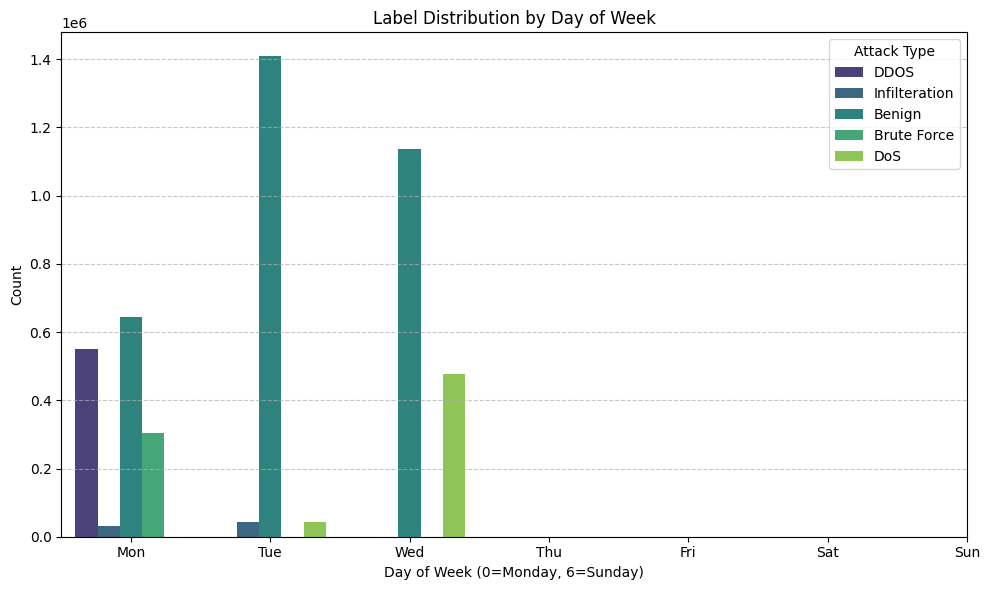

---

최종 'Hour_of_Day' 컬럼 정보 확인:
데이터 타입: float64
고유 값 및 빈도:
Hour_of_Day
-1.219413    714969
-0.977204    944356
-0.734995    340134
-0.492786    278207
-0.250577    137155
 0.476051    259597
 0.718260    452589
 0.960469    575960
 1.202678    565716
 1.444888    369515
Name: count, dtype: int64


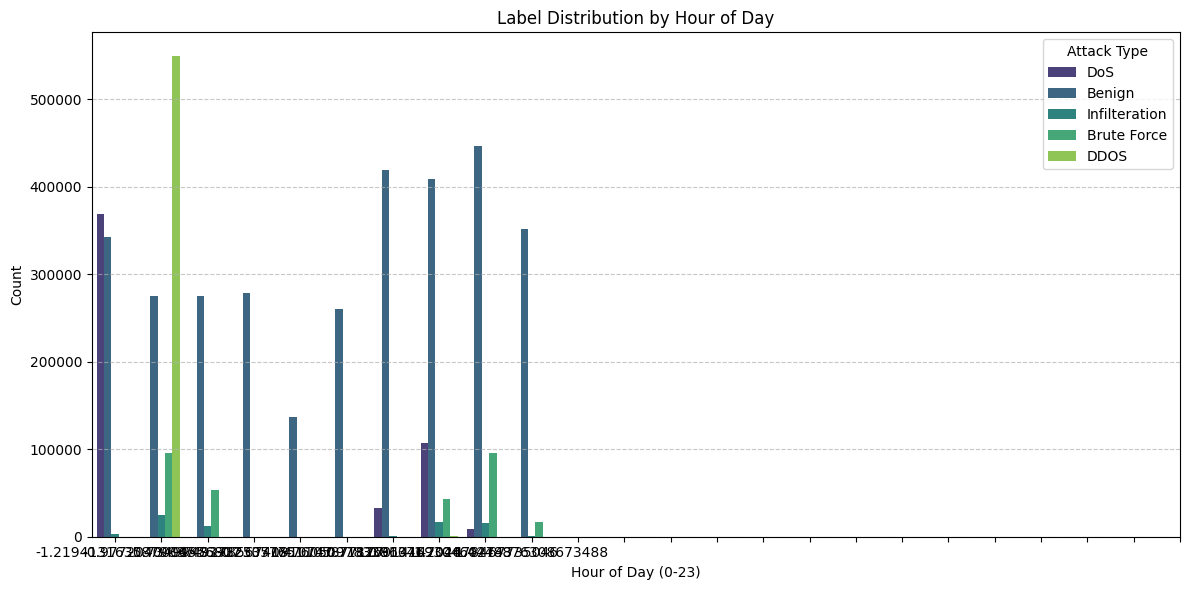

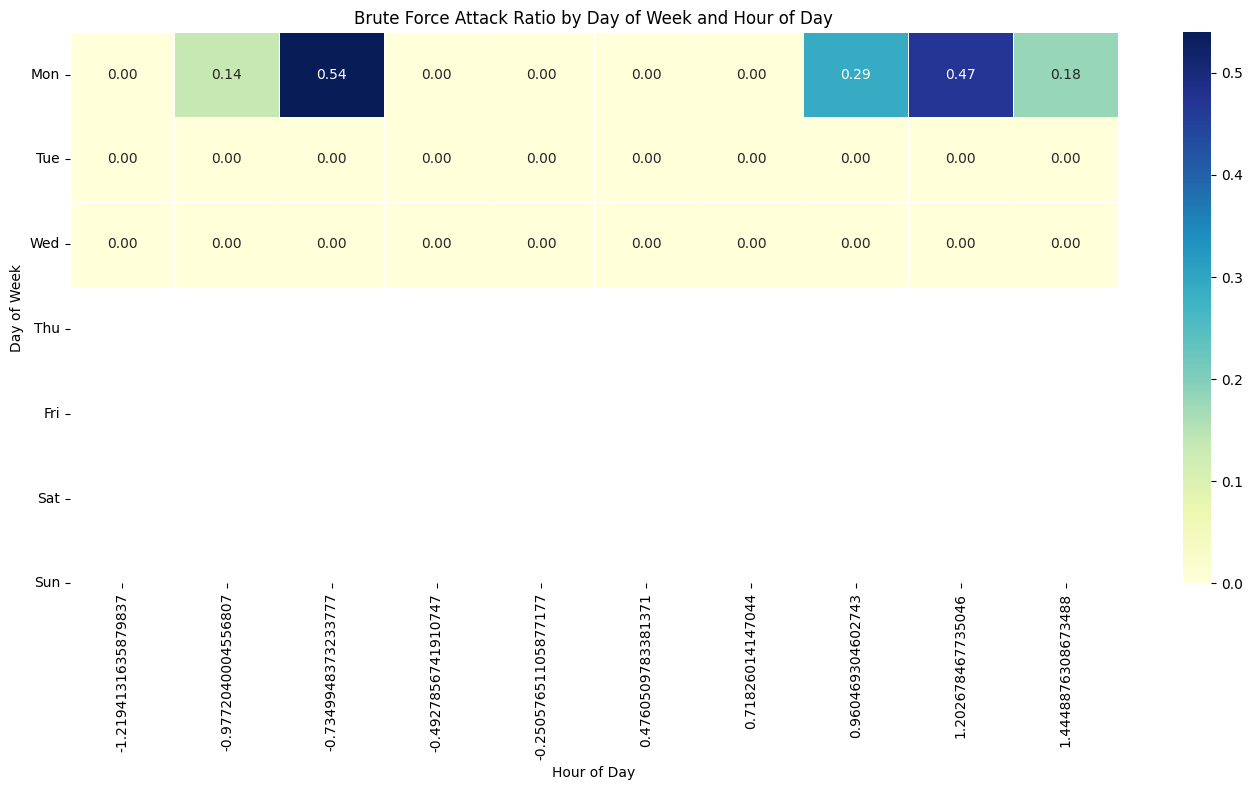

In [15]:
# 1. 요일별 Label 분포 시각화
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df_processed, x='Day_of_Week', hue='Label', palette='viridis')
plt.title('Label Distribution by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.legend(title='Attack Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("---") # 시각화 구분선

# -------------------------------------------------------------
# --- 최종 'Hour_of_Day' 확인 및 시각화 (X축이 제대로 나오는지 확인) ---
print("\n최종 'Hour_of_Day' 컬럼 정보 확인:")
print(f"데이터 타입: {train_df_processed['Hour_of_Day'].dtype}")
print("고유 값 및 빈도:")
print(train_df_processed['Hour_of_Day'].value_counts().sort_index())

plt.figure(figsize=(12, 6))
sns.countplot(data=train_df_processed, x='Hour_of_Day', hue='Label', palette='viridis')
plt.title('Label Distribution by Hour of Day')
plt.xlabel('Hour of Day (0-23)')
plt.ylabel('Count')
plt.xticks(range(0, 24)) # 0시부터 23시까지 모든 시간 표시
plt.legend(title='Attack Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 3. 추가 시각화 (선택 사항): 요일 및 시간대별 공격 비율 (더 심층적인 분석)
# 특정 Label의 비율을 보고 싶을 때 유용

# 예시: 'Brute Force' 공격이 요일/시간대별로 어떻게 분포하는지 히트맵으로 보기
# 먼저 각 요일, 시간대, 라벨별 카운트 계산
df_pivot = train_df_processed.groupby(['Day_of_Week', 'Hour_of_Day', 'Label']).size().unstack(fill_value=0)

# 특정 라벨에 대한 비율 계산 (예: Brute Force)
if 'Brute Force' in df_pivot.columns:
    df_pivot['Brute Force_Ratio'] = df_pivot['Brute Force'] / df_pivot.sum(axis=1)
    df_brute_force_heatmap = df_pivot['Brute Force_Ratio'].unstack(level='Hour_of_Day')

    plt.figure(figsize=(14, 8))
    sns.heatmap(df_brute_force_heatmap, cmap='YlGnBu', annot=True, fmt=".2f", linewidths=.5)
    plt.title('Brute Force Attack Ratio by Day of Week and Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Day of Week')
    plt.yticks(ticks=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5], labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
    plt.tight_layout()
    plt.show()

 Day_of_Week와 Hour_of_Day는 현재 train set에서 Label과 매우 강한 상관관계를 보여주고 있어. 이런 강력한 신호를 단순히 "테스트 세트에 없을 수도 있으니"라는 이유로 제거하는 것은 정보의 손실이 너무 커서 아쉬울 수 있어.

💡 Day_of_Week와 Hour_of_Day를 다루는 최적의 전략 (경진대회용)
이런 상황에서는 단순히 제거하거나 정수형으로 두는 것보다, 시간의 주기성을 모델에 더 잘 알려주는 방법을 사용하는 것이 훨씬 유리해. 바로 사인(Sine) 및 코사인(Cosine) 변환을 이용한 주기적 Feature 변환이야.

왜 이 방법이 좋을까?

주기성 반영: 시간(23시 다음은 0시)과 요일(일요일 다음은 월요일)은 순환하는 특성을 가지고 있어. 단순히 0부터 23까지의 숫자나 0부터 6까지의 숫자로 두면 모델은 '23'과 '0'이 가깝다는 것을 이해하기 어려워. 하지만 사인/코사인 변환을 사용하면 이들을 원형 좌표계의 한 점으로 표현하여 주기적인 관계를 모델이 자연스럽게 학습할 수 있게 돼.

미지의 시간대 처리: 만약 test set에 train set에는 없던 오후 13시, 14시 같은 데이터가 들어온다고 해도, 사인/코사인 변환을 거치면 이 값들도 유효한 좌표값으로 변환돼. 모델은 이전에 학습하지 못한 정확한 패턴은 모르더라도, 시간의 주기성이라는 큰 틀 안에서 새로운 시간대의 데이터를 어느 정도는 유추할 수 있게 되는 거지. 단순히 Feature를 제거하는 것보다 훨씬 유연하게 대처할 수 있어.

정보 손실 최소화: train set 내에서 DDOS가 새벽 2시에 폭발적으로 많다거나, Brute Force가 특정 오전에 집중된다는 강력한 패턴을 그대로 유지하면서 모델이 이를 활용할 수 있도록 해줘.

In [16]:
print("--- Label 컬럼 인코딩 및 train_x, train_y 분리 시작 ---")

# 1. LabelEncoder 객체 생성
label_encoder = LabelEncoder()

# 2. 'Label' 컬럼에 Label Encoding 적용
# fit_transform은 학습(어떤 문자열이 어떤 숫자에 매핑될지)과 변환을 동시에 수행
# 'Label_encoded'라는 새로운 컬럼을 만들고 원본 'Label' 컬럼을 덮어쓰거나 삭제할 수 있습니다.
# 여기서는 'Label_encoded'를 만들고 원본 'Label'은 삭제하겠습니다.
train_df_processed['Label_encoded'] = label_encoder.fit_transform(train_df_processed['Label'])

# 어떤 원본 Label이 어떤 숫자로 매핑되었는지 확인하는 것은 중요합니다.
# 나중에 모델 예측 결과를 다시 원본 Label 이름으로 변환할 때 필요합니다.
print("\n🔥 Label 매핑 정보:")
for i, label in enumerate(label_encoder.classes_):
    print(f"  '{label}' -> {i}")

# 3. train_y (종속 변수) 분리
# 인코딩된 'Label_encoded' 컬럼을 train_y로 사용
train_y = train_df_processed['Label_encoded']
print(f"\n✅ train_y (종속 변수) 분리 완료. Shape: {train_y.shape}")

# 4. train_x (독립 변수) 분리
# 'Label' (원본 문자열)과 'Label_encoded' (새로 만든 인코딩된 라벨) 컬럼을 제외한 모든 컬럼
# 주의: 'Label' 컬럼은 이미 삭제되었거나 'Label_encoded'로 대체되었을 수 있으므로,
# 실제 데이터프레임 상태에 맞게 'Label' 또는 'Label_encoded'를 제외해야 합니다.
# 현재 상황에서는 'Label'이 제거되었고 'Label_encoded'가 있으므로, 'Label_encoded'를 제외해야 합니다.
train_x = train_df_processed.drop(columns=['Label_encoded', 'Label'], errors='ignore')
# errors='ignore'는 만약 'Label' 컬럼이 이미 없으면 무시하라는 의미입니다.

print(f"✅ train_x (독립 변수) 분리 완료. Shape: {train_x.shape}")

print("\n--- Label 인코딩 및 train_x, train_y 분리 완료! ---")


--- Label 컬럼 인코딩 및 train_x, train_y 분리 시작 ---

🔥 Label 매핑 정보:
  'Benign' -> 0
  'Brute Force' -> 1
  'DDOS' -> 2
  'DoS' -> 3
  'Infilteration' -> 4

✅ train_y (종속 변수) 분리 완료. Shape: (4638198,)
✅ train_x (독립 변수) 분리 완료. Shape: (4638198, 46)

--- Label 인코딩 및 train_x, train_y 분리 완료! ---


In [17]:
import pandas as pd # 아직 임포트 안 했다면 다시 해줘!

# 1. 각 컬럼별 결측치 개수 확인
print("\n👉 각 컬럼별 결측치(NaN) 개수:")
missing_values_count = train_df_processed.isnull().sum()
print(missing_values_count)

# 2. 전체 데이터프레임 내 총 결측치 개수 확인
total_missing_values = missing_values_count.sum()
print(f"\n👉 전체 데이터에 존재하는 총 결측치(NaN) 개수: {total_missing_values} 개")

# 3. 결측치가 있는 컬럼만 따로 보기
print("\n👉 결측치가 있는 컬럼 (NaN 개수가 0보다 큰 컬럼만 표시):")
columns_with_nan = missing_values_count[missing_values_count > 0]
if columns_with_nan.empty:
    print("모든 컬럼에 결측치가 없습니다! ✨")
else:
    print(columns_with_nan)

# 4. 결측치가 있는 행의 상위 5개 샘플 확인 (선택 사항)
#    - 주의: 데이터가 크면 이 작업이 오래 걸릴 수 있어!
#    - 결측치가 있는 컬럼이 많을 때 특히 유용해.
print("\n👉 결측치가 있는 행의 상위 5개 샘플 (NaN이 있는 경우):")
rows_with_nan = train_df_processed[train_df_processed.isnull().any(axis=1)]
if rows_with_nan.empty:
    print("결측치가 있는 행이 없습니다.")
else:
    print(rows_with_nan.head()) # 결측치가 있는 행 중 상위 5개만 보여줘.

print("\n--- 결측치(NaN) 확인 완료 ---")


👉 각 컬럼별 결측치(NaN) 개수:
Protocol           0
Flow Duration      0
Tot Fwd Pkts       0
Tot Bwd Pkts       0
TotLen Fwd Pkts    0
TotLen Bwd Pkts    0
Flow Byts/s        0
Flow Pkts/s        0
Flow IAT Mean      0
Flow IAT Std       0
Flow IAT Max       0
Flow IAT Min       0
Pkt Len Min        0
Pkt Len Max        0
Pkt Len Mean       0
Pkt Len Std        0
Pkt Len Var        0
FIN Flag Cnt       0
SYN Flag Cnt       0
RST Flag Cnt       0
PSH Flag Cnt       0
ACK Flag Cnt       0
URG Flag Cnt       0
ECE Flag Cnt       0
Down/Up Ratio      0
Pkt Size Avg       0
Active Mean        0
Active Std         0
Active Max         0
Active Min         0
Idle Mean          0
Idle Std           0
Idle Max           0
Idle Min           0
Label              0
Day_of_Week        0
Hour_of_Day        0
Dst_Port_B         0
Dst_Port_C         0
Dst_Port_D         0
Dst_Port_E         0
Dst_Port_F         0
Dst_Port_G         0
Day_of_Week_sin    0
Day_of_Week_cos    0
Hour_of_Day_sin    0
Hour_of_Day_

In [18]:
# 5단계: 로지스틱 회귀 모델 생성 및 훈련
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
# solver: 최적화에 사용할 알고리즘. 'liblinear'는 작은 데이터셋에, 'lbfgs'는 큰 데이터셋에 일반적으로 잘 작동해.
# random_state: 모델 학습의 무작위성을 고정하여 항상 같은 결과를 얻도록 해줘.
# n_jobs=-1: 모든 CPU 코어를 사용하여 병렬 처리 (훈련 속도 향상).
# 1. RandomForest (가장 빠르고 성능도 좋음)
print("\n🌲 RandomForest 모델 훈련 시작...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # 깊이 제한으로 속도 향상
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_model.fit(train_x, train_y)
print("✅ RandomForest 모델 훈련 완료!")



🌲 RandomForest 모델 훈련 시작...
✅ RandomForest 모델 훈련 완료!


In [19]:
train_y.unique()

array([0, 2, 4, 3, 1])

# 모델 예측

In [20]:
pos_label_list = list(train_y.unique())
pos_label_list.remove(0)

pred_train = rf_model.predict(train_x)
print("F1 Score for Train: ", f1_score(train_y, pred_train, labels=pos_label_list, average="weighted"))

F1 Score for Train:  0.9478609306913998


# 모델 학습

## 데이터 전처리

1. 범주형 데이터를 제거합니다.

## 모델 평가 및 결과 저장

분류 모델을 평가하기 위한 지표는 다양하게 있으며, 저희는 그 중에서 정상 데이터 (Label = `Benign`) 를 제외한 데이터에 대한 **Weighted F1 Score**를 사용합니다.

여러분들이 작성하신 모델의 성능을 평가하기 위해서는, 지시사항에서 명시한 대로 **테스트 데이터**를 불러와서 예측을 수행하고, 그 결과를 반드시 `submission.csv` 파일에 기록하여 제출해야 합니다.

In [22]:
# 테스트 데이터 전처리 시작 (학습 데이터와 동일하게)
print("🔧 테스트 데이터 전처리 시작...")

# 복사본 생성 (원본 test_df 유지)
test_df_processed = test_df.copy()

# --- 1. 결측치 및 inf 값 처리 (메모리 효율적으로) ---
print("🧹 테스트 데이터 정리 시작...")
test_df_processed['Flow Byts/s'] = test_df_processed['Flow Byts/s'].replace([np.inf, -np.inf], np.nan)
test_df_processed['Flow Pkts/s'] = test_df_processed['Flow Pkts/s'].replace([np.inf, -np.inf], np.nan)

# 결측치 및 inf 값을 0으로 대체 (train_x 처리와 동일하게)
test_df_processed = test_df_processed.fillna(0)
print("✅ 테스트 데이터 결측치/inf 값 0 대체 완료.")

# --- 2. Subflow 관련 Feature 제거 (학습 데이터와 동일) ---
# 학습 데이터에서 제거된 Subflow 관련 컬럼 목록을 다시 가져와서 제거
columns_to_drop_subflow = [col for col in test_df_processed.columns if col.startswith('Subflow')]
if columns_to_drop_subflow:
    test_df_processed = test_df_processed.drop(columns=columns_to_drop_subflow)
    print(f"✅ 테스트 데이터 Subflow 관련 Feature {columns_to_drop_subflow} 제거 완료.")
else:
     print("테스트 데이터 Subflow 관련 Feature가 없습니다. (이미 제거되었거나 해당 컬럼 없음)")

# --- 3. CWE Flag Count Feature 제거 (학습 데이터와 동일) ---
column_to_drop_cwe = ['CWE Flag Count']
if column_to_drop_cwe[0] in test_df_processed.columns:
    test_df_processed = test_df_processed.drop(columns=column_to_drop_cwe)
    print(f"✅ 테스트 데이터 '{column_to_drop_cwe[0]}' 컬럼 제거 완료.")
else:
    print(f"테스트 데이터 '{column_to_drop_cwe[0]}' 컬럼이 없습니다. (이미 제거되었거나 이름이 다를 수 있습니다.)")


# --- 4. Timestamp 컬럼 처리 (학습 데이터와 동일) ---
if 'Timestamp' in test_df_processed.columns:
    test_df_processed['Timestamp'] = pd.to_datetime(test_df_processed['Timestamp'], errors='coerce')
    # 테스트 데이터에서는 NaT 값 행을 제거하는 대신, 시간 관련 Feature 생성 후 결측치를 0으로 채웁니다.
    # train 데이터에서는 dropna를 사용했지만, test 데이터에서는 가능한 많은 데이터를 유지하는 것이 좋습니다.
    test_df_processed['Day_of_Week'] = test_df_processed['Timestamp'].dt.dayofweek
    test_df_processed['Hour_of_Day'] = test_df_processed['Timestamp'].dt.hour
    test_df_processed = test_df_processed.drop(columns=['Timestamp'])

    # 새로 생성된 시간 Feature의 NaN 값 (Timestamp 변환 오류로 인해 발생)을 0으로 채웁니다.
    test_df_processed['Day_of_Week'].fillna(0, inplace=True)
    test_df_processed['Hour_of_Day'].fillna(0, inplace=True)

    print("✅ 테스트 데이터 Timestamp 컬럼 처리 및 Day_of_Week, Hour_of_Day 생성 완료.")
else:
    print("테스트 데이터 'Timestamp' 컬럼이 없습니다. Timestamp 처리를 건너뜁니다.")

# --- 5. Day_of_Week와 Hour_of_Day 주기적 변환 (학습 데이터와 동일) ---
test_df_processed['Day_of_Week_sin'] = np.sin(2 * np.pi * test_df_processed['Day_of_Week'] / 7)
test_df_processed['Day_of_Week_cos'] = np.cos(2 * np.pi * test_df_processed['Day_of_Week'] / 7)
test_df_processed['Hour_of_Day_sin'] = np.sin(2 * np.pi * test_df_processed['Hour_of_Day'] / 24)
test_df_processed['Hour_of_Day_cos'] = np.cos(2 * np.pi * test_df_processed['Hour_of_Day'] / 24)
print("✅ 테스트 데이터 Day_of_Week 및 Hour_of_Day 주기적 변환 완료.")

# --- 6. Dst Port 원-핫 인코딩 (학습 데이터와 동일) ---
# 학습 데이터에서 사용된 Dst Port 컬럼 목록을 알고 있어야 합니다.
# train_df_processed.columns에서 Dst_Port_로 시작하는 컬럼을 확인하여 동일하게 적용해야 합니다.
# 만약 test 데이터에 train 데이터에 없던 새로운 Dst Port 값이 있다면, get_dummies는 자동으로 처리합니다.
# 하지만 학습 데이터에 없던 컬럼이 test 데이터에 생기면 예측 시 문제가 될 수 있으므로,
# 학습 데이터 컬럼에 맞춰주는 작업이 필요합니다. (아래 컬럼 순서 맞추기 단계에서 처리)
test_df_processed = pd.get_dummies(test_df_processed, columns=['Dst Port'], prefix='Dst_Port', drop_first=True)
print("✅ 테스트 데이터 Dst Port 원-핫 인코딩 완료.")

# PowerTransformer 적용 대상 컬럼 목록 (train과 동일)
# train 셀에서 정의된 final_cols_to_transform 리스트가 여기에 접근 가능해야 합니다.
# 만약 접근 불가능하다면, 이 리스트를 다시 정의하거나 train 셀과 합쳐야 합니다.
# 여기서는 final_cols_to_transform 변수가 전역 또는 상위 스코프에 정의되어 있다고 가정합니다.

# 테스트 데이터에 실제로 존재하는 컬럼만 선택하여 변환 적용
cols_to_transform_test = [col for col in final_cols_to_transform if col in test_df_processed.columns]

if cols_to_transform_test:
    print(f"\n7. 테스트 데이터 Power Transformer (Yeo-Johnson) 적용 컬럼: {cols_to_transform_test}")
    # PowerTransformer 객체는 이미 train 데이터에서 fit 된 상태여야 합니다.
    test_df_processed[cols_to_transform_test] = power_transformer.transform(test_df_processed[cols_to_transform_test])
    print("✅ 테스트 데이터 Power Transformer 적용 완료.")
else:
    print("7. 테스트 데이터에 Power Transformer를 적용할 컬럼이 없습니다.")


# --- 8. StandardScaler 적용 (학습 데이터에서 fit된 scaler 사용) ---

# StandardScaler 적용 대상 컬럼 목록 (train과 동일)
# train 셀에서 정의된 cols_to_scale_standard 리스트가 여기에 접근 가능해야 합니다.
# 만약 접근 불가능하다면, 이 리스트를 다시 정의하거나 train 셀과 합쳐야 합니다.
# 여기서는 cols_to_scale_standard 변수가 전역 또는 상위 스코프에 정의되어 있다고 가정합니다.

# 테스트 데이터에 실제로 존재하는 컬럼만 선택하여 스케일링 적용
cols_to_scale_standard_test = [col for col in cols_to_scale_standard if col in test_df_processed.columns]

if cols_to_scale_standard_test:
    print(f"\n8. 테스트 데이터 StandardScaler 적용 컬럼: {cols_to_scale_standard_test}")
    # StandardScaler 객체는 이미 train 데이터에서 fit 된 상태여야 합니다.
    test_df_processed[cols_to_scale_standard_test] = scaler.transform(test_df_processed[cols_to_scale_standard_test])
    print("✅ 테스트 데이터 StandardScaler 적용 완료.")
else:
    print("8. 테스트 데이터에 StandardScaler를 적용할 컬럼이 없습니다.")


# --- 9. 학습 데이터와 테스트 데이터의 컬럼 순서 및 존재 여부 일치시키기 ---
# 모델은 훈련 시와 동일한 순서의 Feature를 기대합니다.
# train_x의 컬럼 목록을 기준으로 test_df_processed의 컬럼을 재정렬하고, 없는 컬럼은 0으로 채웁니다.
train_cols = train_x.columns.tolist()
test_cols = test_df_processed.columns.tolist()

# train에는 있지만 test에는 없는 컬럼을 test에 추가하고 0으로 채우기
missing_in_test = set(train_cols) - set(test_cols)
for col in missing_in_test:
    test_df_processed[col] = 0
    print(f"💡 테스트 데이터에 누락된 컬럼 '{col}'을 0으로 채웠습니다.")

# test에는 있지만 train에는 없는 컬럼을 test에서 제거하기
extra_in_test = set(test_cols) - set(train_cols)
for col in extra_in_test:
    test_df_processed = test_df_processed.drop(columns=[col])
    print(f"🗑️ 테스트 데이터에 추가로 있는 컬럼 '{col}'을 제거했습니다.")


# train_x의 컬럼 순서대로 test_df_processed 재정렬
test_x = test_df_processed[train_cols]
print("✅ 테스트 데이터 컬럼 순서 학습 데이터와 일치 완료.")

print("\n✨ 테스트 데이터 전처리 완료! ✨")
print("\n--- 최종 test_x 컬럼 목록 ---")
print(test_x.columns)
print("\n--- 최종 test_x DataFrame 정보 ---")
print(test_x.info())
print("\n--- 최종 test_x head ---")
print(test_x.head())

🔧 테스트 데이터 전처리 시작...
🧹 테스트 데이터 정리 시작...
✅ 테스트 데이터 결측치/inf 값 0 대체 완료.
✅ 테스트 데이터 Subflow 관련 Feature ['Subflow Fwd Pkts', 'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts'] 제거 완료.
✅ 테스트 데이터 'CWE Flag Count' 컬럼 제거 완료.
✅ 테스트 데이터 Timestamp 컬럼 처리 및 Day_of_Week, Hour_of_Day 생성 완료.
✅ 테스트 데이터 Day_of_Week 및 Hour_of_Day 주기적 변환 완료.
✅ 테스트 데이터 Dst Port 원-핫 인코딩 완료.

7. 테스트 데이터 Power Transformer (Yeo-Johnson) 적용 컬럼: ['Flow Duration', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Flow Byts/s', 'Flow Pkts/s', 'Pkt Len Var', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Active Mean', 'Active Std', 'Active Max', 'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean', 'Pkt Len Std', 'Down/Up Ratio', 'Pkt Size Avg']
✅ 테스트 데이터 Power Transformer 적용 완료.

8. 테스트 데이터 StandardScaler 적용 컬럼: ['Protocol', 'FIN Flag Cnt', 'SYN Flag Cnt', 'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt', 'ECE Flag Cnt

In [23]:
# 전처리된 test_x를 사용하여 예측 수행
print("🚀 테스트 데이터 예측 시작...")
# rf_model은 이미 train 데이터로 훈련되어 있습니다.
pred_test = rf_model.predict(test_x)
print("✅ 테스트 데이터 예측 완료.")

# 예측 결과를 원본 Label 이름으로 다시 변환 (LabelEncoder 사용)
# label_encoder 객체는 train 데이터 인코딩 시 fit 되어 있어야 합니다.
predicted_labels = label_encoder.inverse_transform(pred_test)
print("✅ 예측 결과 Label 디코딩 완료.")

# submission DataFrame 생성 및 저장
submission = pd.read_csv(os.path.join(data_dir, "test.csv"), index_col=0) # 원본 test.csv를 다시 불러와 index를 맞춥니다.
submission["Label"] = predicted_labels # 예측 결과를 Label 컬럼에 할당
submission = submission[["Label"]] # Label 컬럼만 남김

# submission.csv 파일로 저장
submission.to_csv("submission.csv")

print("\n--- submission.csv 파일 생성 완료 ---")
print("\n✨ 제출할 submission.csv 파일이 성공적으로 생성되었습니다. ✨")

🚀 테스트 데이터 예측 시작...
✅ 테스트 데이터 예측 완료.
✅ 예측 결과 Label 디코딩 완료.

--- submission.csv 파일 생성 완료 ---

✨ 제출할 submission.csv 파일이 성공적으로 생성되었습니다. ✨


### 결과 검증

`submission.csv` 파일을 다시 불러와 올바르게 값을 채웠는지 다시 한번 확인합니다.

In [24]:
submission = pd.read_csv("submission.csv", index_col=0)
submission

,Label
unique_id,
8093282X,DDOS
5372892S,Benign
3627842Z,Brute Force
7554377I,Benign
6650145Z,Brute Force
...,...
1955149C,Benign
8749551J,Benign
1143189F,Benign


### 제출

`submission.csv` 파일이 제대로 생성됐다면, 우측 상단의 제출 버튼을 눌러 `submission.csv` 파일을 제출하고 리더보드에서 점수를 확인하세요.

- 팀당 제출 가능 횟수는 **1일 20회** 입니다. 팀 내 모든 구성원이 제출 가능하나 팀 제출 횟수는 팀 단위로 합산됩니다.
- 최종 채점 기준: Private score 50% + Public score 50%
- 리더보드에는 **마지막으로 제출한 결과**의 Public 점수가 공개됩니다.
- 최종 채점에는 마지막으로 제출된 결과로 평가됩니다.

## 경진대회 종료 전 제출을 희망하는 코드와 결과물로 마지막 제출을 수행하세요.
## 반드시 마지막 제출된 프로젝트의 전체 파일을 압축하여 별도의 제출 공간에 제출하세요.

다음 파일들을 압축하여 별도의 제출공간에 제출해야 합니다.
- `code.ipynb`: 전체 프로젝트 진행 파일
- `submission.csv`: 예측 결과 파일
- 외부 데이터 사용 시: 원본 데이터 파일(혹은 데이터 다운로드 코드)
    - 외부 데이터에 대한 전처리 과정은 프로젝트 코드 내에 포함되어야 함
- 기타 프로젝트 실행에 필요한 모든 파일